In [55]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import Float, Array
import matplotlib.pyplot as plt
from jax.scipy.stats import beta

In [33]:
EPSILON = 0.0000000001


def cross_distance(
    x1: Float[Array, "N D"], x2: Float[Array, "N_ D"]
) -> Float[Array, "N_ N"]:
    return jax.vmap(jax.vmap(_squared_distance, in_axes=(None, 0)), in_axes=(0, None))(
        x1, x2
    )


def pairwise_distance(x: Float[Array, "N D"]) -> Float[Array, "N N"]:
    return cross_distance(x, x)


def _squared_distance(x1: Float[Array, "D"], x2: Float[Array, "D"]) -> Float[Array, ""]:
    return jnp.sum((x1 - x2) ** 2)


def _solve_interpolation(
    x: Float[Array, "N Din"],
    y: Float[Array, "N Dout"],
    order: int,
    regularization_weight: Array | float,
) -> tuple[Array, Array]:
    n, d = x.shape
    n, k = y.shape
    matrix_a = _phi(pairwise_distance(x), order)  # [n, n]

    if regularization_weight > 0:
        identity_matrix = jnp.eye(n)  # [n, n]
        matrix_a += regularization_weight * identity_matrix  # [n, n]

    matrix_b = jnp.concatenate([x, jnp.ones([n, 1])], -1)  # [n, d + 1]

    # [n + d + 1, n]
    left_block = jnp.concatenate([matrix_a, matrix_b.T], 0)

    num_b_cols = matrix_b.shape[-1]  # d + 1
    lhs_zeros = jnp.zeros([num_b_cols, num_b_cols])
    right_block = jnp.concatenate([matrix_b, lhs_zeros], 0)  # [n + d + 1, d + 1]
    lhs = jnp.concatenate([left_block, right_block], -1)  # [n + d + 1, n + d + 1]
    lhs += jnp.eye(n + d + 1) * EPSILON

    rhs_zeros = jnp.zeros([d + 1, k])
    rhs = jnp.concatenate([y, rhs_zeros], 0)  # [n + d + 1, k]
    w_v = jnp.linalg.solve(lhs, rhs)
    w = w_v[:n, :]
    v = w_v[n:, :]

    return w, v


def _phi(r: Array | float, order: int) -> Array | float:
    if order == 1:
        r = jnp.maximum(r, EPSILON)
        r = jnp.sqrt(r)
        return r
    elif order == 2:
        return 0.5 * r * jnp.log(jnp.maximum(r, EPSILON))
    elif order == 4:
        return 0.5 * jnp.square(r) * jnp.log(jnp.maximum(r, EPSILON))
    elif order % 2 == 0:
        r = jnp.maximum(r, EPSILON)
        return 0.5 * jnp.power(r, 0.5 * order) * jnp.log(r)
    else:
        r = jnp.maximum(r, EPSILON)
        return jnp.power(r, 0.5 * order)

In [ ]:
class BernsteinBijector:

    def __init__(self, theta: Float[Array, "order"]):
        self.theta = self.constrain_theta(theta)
        self.order = theta.shape[-1]
        self.alpha = [x for x in jnp.arange(1.0, self.order + 1.0)]
        self.beta = self.alpha[::-1]

    def get_bernstein_poly(self):

        def bernstein_poly(x):
            bx = beta.pdf(x[..., jnp.newaxis], self.alpha, self.beta)
            z = jnp.mean(bx * self.theta, axis=-1)
            return z

        return bernstein_poly



    def get_bernstein_poly_jac(self):

        def bernstein_poly_jac(y):
            by = beta.pdf(y[..., jnp.newaxis], self.alpha[:-1], self.beta[1:])
            dtheta = self.theta[..., 1:] - self.theta[..., 0:-1]
            dz_dy = jnp.sum(by * dtheta, axis=-1)
            return dz_dy

        return bernstein_poly_jac

    @classmethod
    def constrain_theta(
        cls: type,
        theta_unconstrained: Float[Array, "order"],
        fn=jax.nn.softplus,
    ) -> Float[Array, "order"]:
        d = jnp.concatenate(
            (
                jnp.zeros_like(theta_unconstrained[..., :1]),
                theta_unconstrained[..., :1],
                fn(theta_unconstrained[..., 1:]) + 1e-4,
            ),
            axis=-1,
        )
        return jnp.cumsum(d[..., 1:], axis=-1)

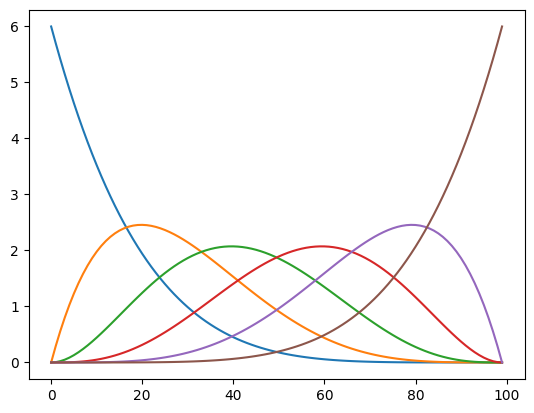

In [60]:
plt.plot(
    beta.pdf(
        jnp.linspace(0.0, 1.0, 100)[:, None],
        jnp.arange(1.0, 7.0),
        jnp.arange(6.0, 0.0, -1.0),
    )
)

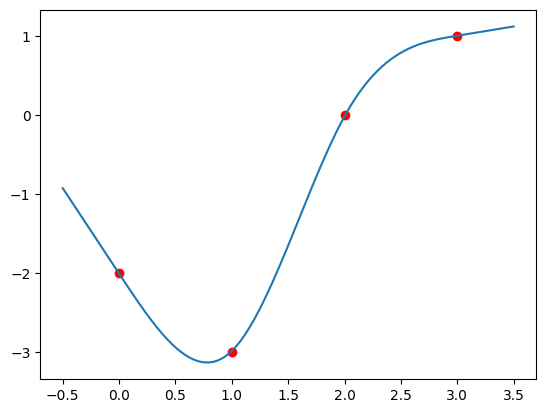

In [53]:
order = 3
x = np.asarray([0.0, 1.0, 2.0, 3.0])[:, None]
y = np.asarray([-2.0, -3.0, 0.0, 1.0])[:, None]

w, v = _solve_interpolation(x, y, order, 0.01)

xt = jnp.linspace(-0.5, 3.5, 100)[:, None]

phi_kxt = _phi(cross_distance(xt, x), order)
rbf_term = jnp.dot(phi_kxt, w)
linear_term = jnp.dot(jnp.concatenate([xt, jnp.ones([xt.shape[0], 1])], -1), v)
yt = rbf_term + linear_term

plt.plot(np.squeeze(xt), np.squeeze(yt))
plt.scatter(x, y, c="r")

In [79]:

def get_beta_params(order):
    alpha = jnp.arange(1., order + 1.)
    beta = alpha[::-1]
    return alpha, beta


def get_bernstein_poly(theta):
    theta_shape = theta.shape
    order = theta_shape[-1]
    beta_params = get_beta_params(order)

    def bernstein_poly(x):
        bx = beta.pdf(x[..., jnp.newaxis], *beta_params)
        z = jnp.mean(bx * theta, axis=-1)
        return z

    return bernstein_poly


def get_beta_derivative_params(order):
    alpha = jnp.arange(1., order)
    beta = alpha[::-1]
    return alpha, beta


def get_bernstein_poly_jac(theta):
    theta_shape = theta.shape
    order = theta_shape[-1]

    beta_der_params = get_beta_derivative_params(order)

    def bernstein_poly_jac(y):
        by = beta.pdf(y[..., jnp.newaxis], *beta_der_params)
        dtheta = theta[..., 1:] - theta[..., 0:-1]
        dz_dy = jnp.sum(by * dtheta, axis=-1)
        return dz_dy

    return bernstein_poly_jac


def constrain_thetas(theta_unconstrained, range_min=None, range_max=None, fn=jax.nn.softplus):

    d = jnp.concatenate(
        (
            jnp.zeros_like(theta_unconstrained[..., :1]),
            theta_unconstrained[..., :1],
            fn(theta_unconstrained[..., 1:]) + 1e-4,
        ),
        axis=-1,
    )

    return jnp.cumsum(d[..., 1:], axis=-1)


class BernsteinBijector:
    """Initializes a Bernstein bijector."""

    def __init__(self, thetas):
        self.thetas = constrain_thetas(thetas)

    def forward(self, x):
        """Computes y = f(x)."""
        bernstein_poly = get_bernstein_poly(self.thetas)
        clip = 1e-7
        x = jnp.clip(x, clip, 1.0 - clip)
        return bernstein_poly(x)

    def forward_log_det_jacobian(self, x):
        """Computes log|det J(f)(x)|."""
        bernstein_poly = get_bernstein_poly_jac(self.thetas)
        clip = 1e-7
        x = jnp.clip(x, clip, 1.0 - clip)
        return jnp.log(bernstein_poly(x))

    def inverse(self, y):
        """Computes x = f^{-1}(y)."""
        event_shape = self.thetas.shape[:-1]
        n_points = 4
        clip = 1e-7
        x_fit = jnp.linspace(clip, 1 - clip, n_points)[..., np.newaxis] * jnp.ones(
            (1,) + event_shape
        )
        y_fit = self.forward(x_fit)

        def inp(y, y_fit, x_fit):
            return jnp.interp(y, y_fit, x_fit)

        x = jax.vmap(inp, in_axes=-1)(y, y_fit, x_fit)
        return x

    def forward_and_log_det(self, x):
        """Computes y = f(x) and log|det J(f)(x)|."""
        y = self.forward(x)
        logdet = self.forward_log_det_jacobian(x)
        return y, logdet

    def inverse_and_log_det(self, y):
        """Computes y = f(x) and log|det J(f)(x)|."""
        y = self.inverse(y)
        logdet = 0
        return y, logdet

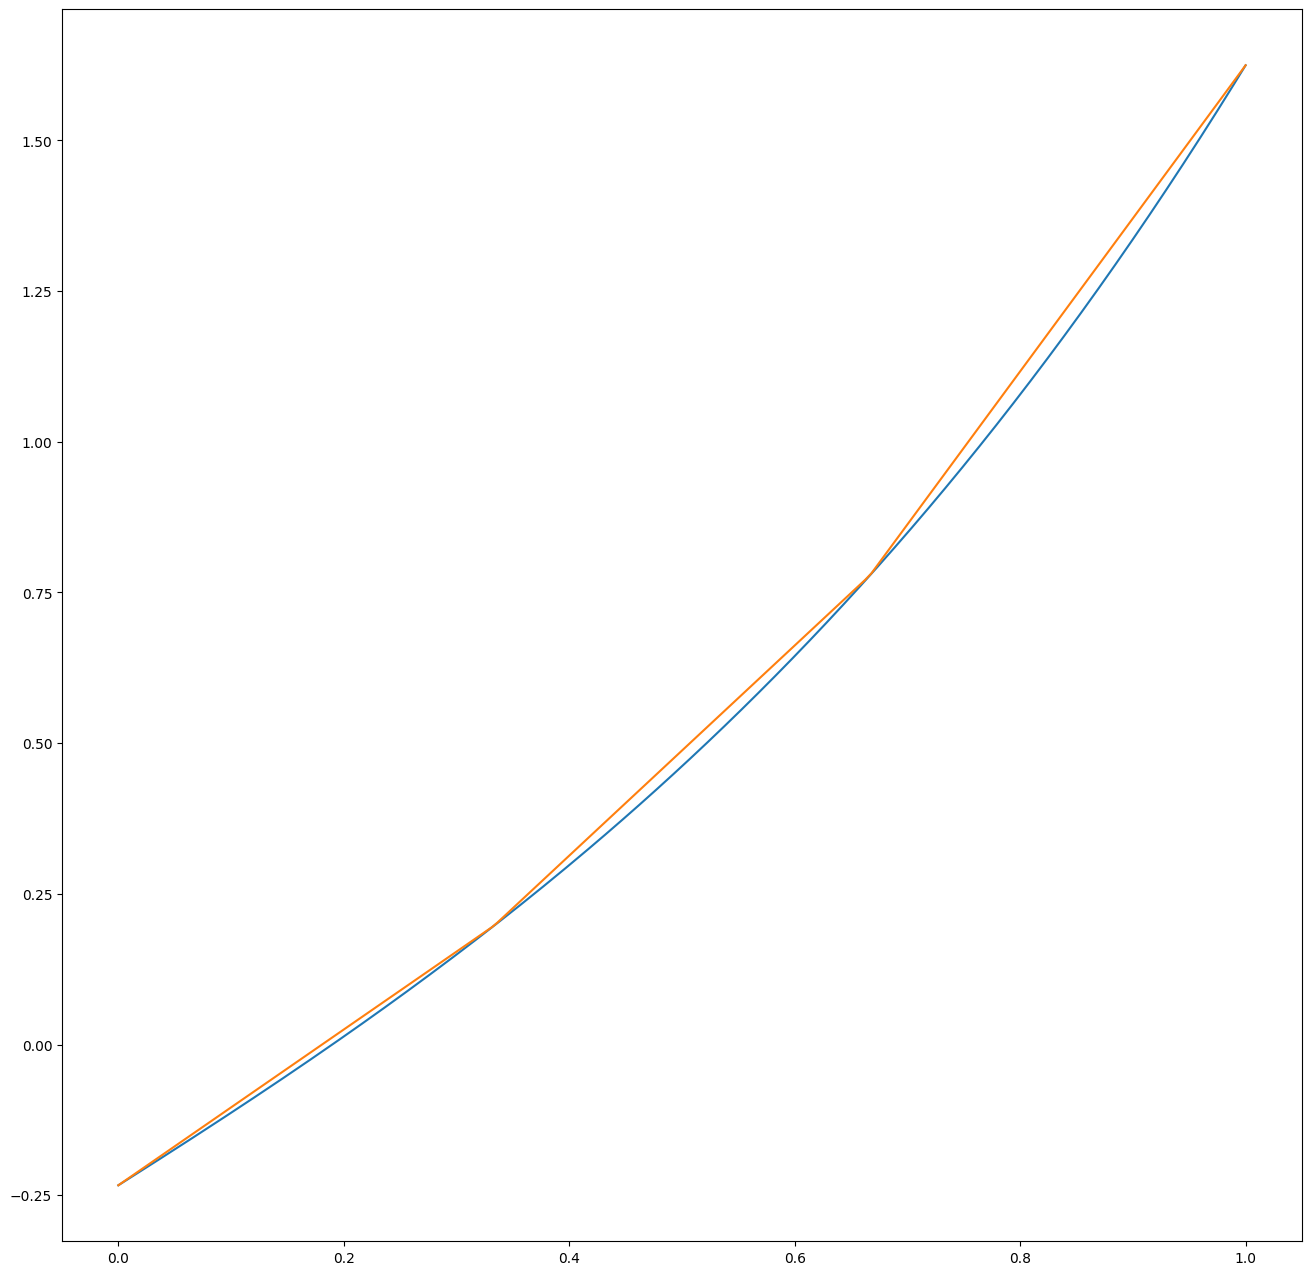

In [81]:
M = 4
# ensure monotonicity
bs = BernsteinBijector(np.random.normal(0, 1, (M,)))
yy = np.linspace(0, 1, 200, dtype=np.float32)
zz = bs.forward(yy)
# Prevent caching -> use spline interpolation
zi = zz + 1e-15 * np.random.random(zz.shape)
yyy = bs.inverse(zi[:,None])

plt.figure(figsize=(16, 16))
plt.plot(yy, zz)
plt.plot(yyy[0], zi)